# DAMASK tutorial

- creating necessary inputs for damask
- defining the elastoplastic model(isotropic hardening) for tensile test
- runing the damask jobs

here more option is given to the user to select from damask python package itself.

Author: Yang Bai

Date  : 23.02.2022

## Importing libraries and creatign Project

In [1]:
from pyiron_continuum import Project
from damask import Rotation # this will be used in material configuration

/home/users/menonsqr/miniconda3/envs/pyiron-continuum/lib/python3.8/site-packages/tqdm-4.63.0-py3.8.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### create a 'project' to manage all the configurations for a tensile test

In [2]:
pr = Project('isotropic')
pr.remove_jobs(silently=True) # automatically delete the existing project folder

/tmp/ipykernel_75353/2047636551.py:2: DeprecationWarning: pyiron_base.project.generic.remove_jobs_silently is deprecated: Use pr.remove_jobs(silently=True) rather than pr.remove_jobs_silently()..
  pr.remove_jobs_silently(recursive=True) # automatically delete the existing project folder


### Creating the Damask job

In [3]:
job = pr.create.job.DAMASK('damask_job')

In [4]:
job.elasticity(type= 'Hooke', C_11= 106.75e9,
                                   C_12= 60.41e9, C_44=28.34e9)

#### for a damask job, one needs:
- geometry information(i.e., the mesh)
- material configuration(material.yaml)
- boundary conditions(i.e., loading.yaml)

### For material configuration
#### for elastoplastic material

#### for the number of grains and grids

In [5]:
job.plasticity(type='isotropic',dot_gamma_0=0.001,
                    n=20.,xi_0=0.3e+6,
                    xi_inf=0.6e+6,a=2.,
                    h_0=1.e+6, # hardening modulus
                    M=1.,h=1.,
                    dilatation=True,output=['xi'])
# for the details of isotropic model, one is referred to https://doi.org/10.1016/j.scriptamat.2017.09.047

#### for material configuration, you need
- phase
- roation
- homogenization

In [6]:
job.phase(composition='Aluminum', lattice= 'cF',
             output_list=['F', 'P', 'F_e', 'F_p', 'L_p', 'O'])
job.rotation(Rotation.from_random, 4)

job.homogenization(method='SX', 
                 parameters={'N_constituents': 1,
                             "mechanical": {"type": "pass"}})

# now you can define your material.yaml configuration
job.material('Aluminum')

## For geometry information

In [7]:
job.grid(method="voronoi_tessellation", box_size=1.0e-5, grid_dim=16, num_grains=4)

## For boundary conditions (loading)

In [8]:
load_step =[{'mech_bc_dict':{'dot_F':[1e-3,0,0, 0,'x',0,  0,0,'x'],
                            'P':['x','x','x', 'x',0,'x',  'x','x',0]},
            'discretization':{'t': 10.,'N': 40},
            'additional': {'f_out': 4}
           },{'mech_bc_dict':{'dot_F':[1e-3,0,0, 0,'x',0,  0,0,'x'],
                              'P':['x','x','x', 'x',0,'x',  'x','x',0]},
            'discretization':{'t': 60.,'N': 60},
            'additional': {'f_out': 4}
           }]

solver = job.list_solvers()[0] # choose the mechanis solver
job.loading(solver=solver, load_steps=load_step)

In [10]:
job.run() # running your job, if you want the parallelization you can modify your 'pyiron/damask/bin/run_damask_3.0.0.sh file'

The job damask_job was saved and received the ID: 26


2022-03-22 15:01:47,311 - pyiron_log - WARNING - Job aborted
2022-03-22 15:01:47,312 - pyiron_log - WARNING - --------------------------------------------------------------------------
mpiexec was unable to find the specified executable file, and therefore
did not launch the job.  This error was first reported for process
rank 0; it may have occurred for other processes as well.

NOTE: A common cause for this error is misspelling a mpiexec command
      line parameter option (remember that mpiexec interprets the first
      unrecognized command line token as the executable).

Node:       musashi
Executable: DAMASK_grid
--------------------------------------------------------------------------



RuntimeError: Job aborted

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varepsilon_x$$_x$', ylabel='$\\sigma_x$$_x$(Pa)'>)

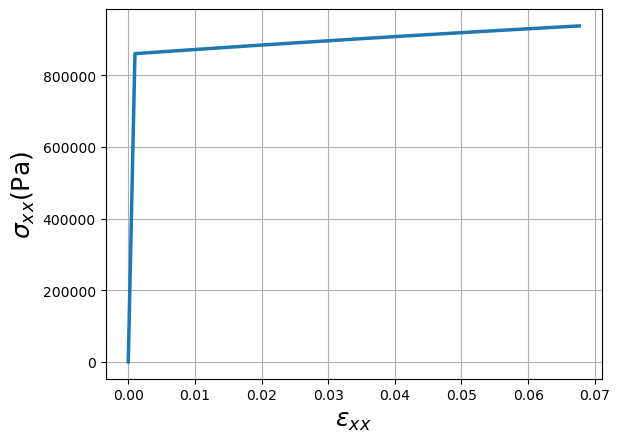

In [10]:
# plot the strain_xx vs stress_xx profile
job.plot_stress_strain(component='xx')

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varepsilon_{vM}$', ylabel='$\\sigma_{vM}$ (Pa)'>)

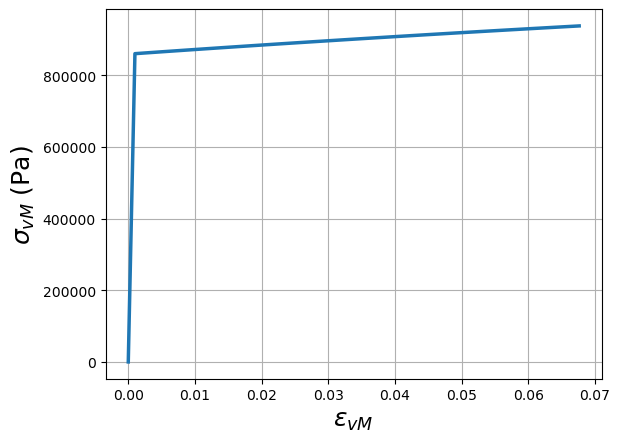

In [11]:
# plot the vonMises-strain vs vonMises-stress profile
job.plot_stress_strain(von_mises=True)

In [12]:
job.writeresults2vtk() # you can also save all the field quantities to vtk files

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
